# AI4PH Data Challenge

Summer 2024

**Yves Nsoga** 
PhD Candidate Biomedical Engineering
University of Calgary
[Data Intelligence for Health Lab](https://cumming.ucalgary.ca/dih)    

In [2]:
# import all packages here 

import pandas as pd
import numpy as np
import cv2

import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import imutils

In [19]:
# Util functions here 
def stich_image(img_paths: list):
    """stich images with  overlaping to  generate a panoramic view of the POstal  code

    :param img_paths: a list  of image paths
    return panoramic_image
    """
    imgs = []
    for img_path in img_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
    stitchy = cv2.createStitcher() if imutils.is_cv3() else cv2.Stitcher_create()
    (dummy, stiched_output) = stitchy.stitch(imgs)
    if dummy == cv2.STITCHER_OK:
        return stiched_output
    
def crop(stitched: np.array):
    """crop stiched image

    :param image: Image to resize
    :param dimension:  Expected (width, height) of new image, defaults to (800,250)
    :Returns image: Resized image
    """
    stitched = cv2.copyMakeBorder(stitched, 10, 10, 10, 10,
			cv2.BORDER_CONSTANT, (0, 0, 0))
    # convert the stitched image to grayscale and threshold it
    # such that all pixels greater than zero are set to 255
    # (foreground) while all others remain 0 (background)
    gray = cv2.cvtColor(stitched,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]
	# find all external contours in the threshold image then find
	# the *largest* contour which will be the contour/outline of
	# the stitched image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
	# allocate memory for the mask which will contain the
	# rectangular bounding box of the stitched image region
    mask = np.zeros(thresh.shape, dtype="uint8")
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)
    minRect = mask.copy()
    sub = mask.copy()
	# keep looping until there are no non-zero pixels left in the
	# subtracted image
    while cv2.countNonZero(sub) > 0:
		# erode the minimum rectangular mask and then subtract
		# the thresholded image from the minimum rectangular mask
		# so we can count if there are any non-zero pixels left
        minRect = cv2.erode(minRect, None)
        sub = cv2.subtract(minRect, thresh)
    cnts = cv2.findContours(minRect.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    (x, y, w, h) = cv2.boundingRect(c)
	# use the bounding box coordinates to extract the our final
	# stitched image
    stitched = stitched[y:y + h, x:x + w]
    return stitched

def resize(image:np.array,dimension=tuple):
    resized_image = cv2.resize(
    image, dimension, interpolation=cv2.INTER_LINEAR)
    return resized_image

class zone_panorama_dataset(Dataset):
    """
    """
    def __init__(self,csv_file,root_dir,transform=None):
        """_summary_

        :param csv_file: _description_
        :type csv_file: _type_
        :param root_dir: _description_
        :type root_dir: _type_
        :param transform: _description_, defaults to None
        :type transform: _type_, optional
        """
        self.depravation_indices_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform =transform

    def __len__(self):
        return len(os.listdir(self.root_dir))
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index =index.tolist()
        image_list = []
        image_path = os.path.join(self.root_dir,
                                  self.depravation_indices_data.iloc[index, 1])
        postal_codes = os.listdir(self.root_dir)
        image_path = os.path.join(self.root_dir,
                                               postal_codes[index])
        
        try:
            for images in os.listdir(image_path):
                if (images.endswith(".png")):
                    image_list.append(os.path.join(image_path,
                                                    images))
            panorama_view = stich_image(image_list)
            image = crop(panorama_view)
            sample = {"image": image,
                    "POSTAL":postal_codes[index],
                      "SCOREMAT": self.depravation_indices_data["SCOREMAT"].loc[self.depravation_indices_data["POSTALCODE_15"] == postal_codes[index]].values[0],
                      "SCORESOC": self.depravation_indices_data["SCORESOC"].loc[self.depravation_indices_data["POSTALCODE_15"] == postal_codes[index]].values[0] }
            if self.transform:
                sample = self.transform(sample)
            return sample
        except :
            pass


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image= sample['image']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        trans = transforms.Compose([transforms.ToTensor()])
        sample['image'] = trans(sample['image'])
        sample["SCOREMAT"]= sample["SCOREMAT"].float()
        sample["SCORESOC"] = sample["SCORESOC"].float()
        # image = image.transpose((2, 0, 1))
        return sample


class Resize(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        trans = transforms.Compose([transforms.Resize(size=(250, 450))])
        sample['image'] = trans(sample['image'])
        # image = image.transpose((2, 0, 1))
        return sample
    

class Net(nn.Module):
    """Convolution  neural network 

    :param nn: _description_
    :type nn: _type_
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(84375, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x)  # flatten all dimensions except batch
        x = F.relu(x)
        x = self.fc1(x)
        return x


net = Net()

In [20]:
depravation_dataset= zone_panorama_dataset(
    csv_file="../Data challenge dataset_complete_no_duplication.csv", root_dir="../GSV_Images_AB")
depravation_dataset_transformed = zone_panorama_dataset(
    csv_file="../Data challenge dataset_complete_no_duplication.csv", root_dir="../GSV_Images_AB", transform=transforms.Compose([ToTensor(), Resize()]))

<Figure size 640x480 with 0 Axes>

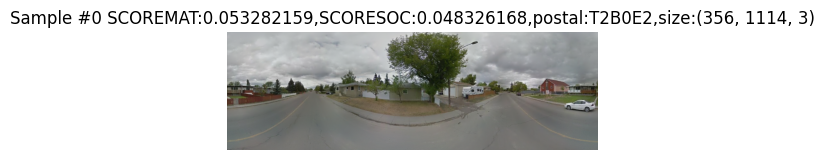

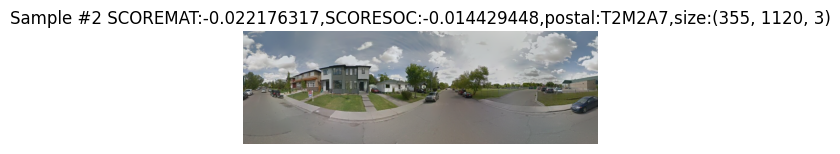

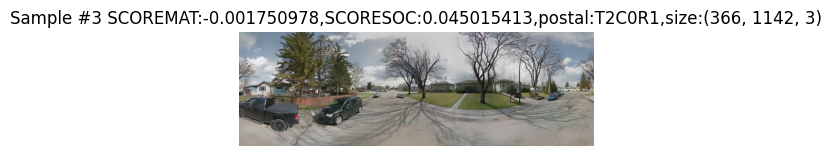

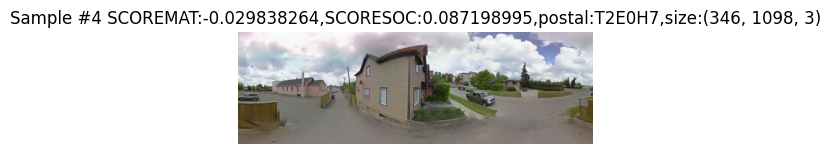

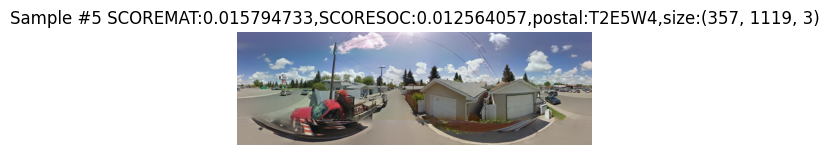

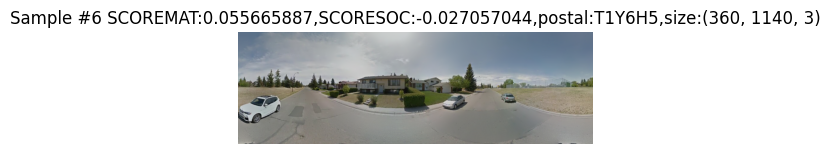

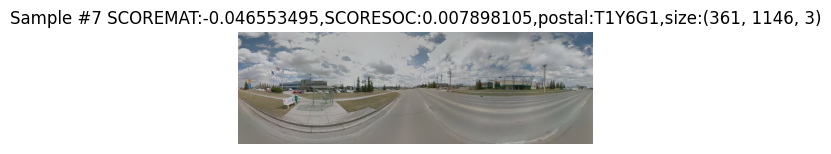

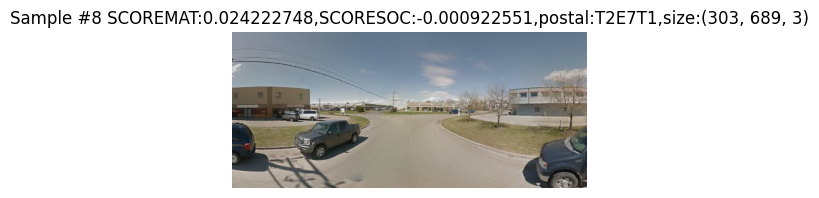

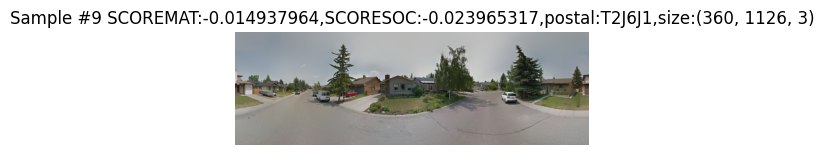

In [21]:
fig = plt.figure()

for i, sample in enumerate(depravation_dataset):
    if sample:
        plt.figure(figsize=[40, 40])
        ax = plt.subplot(1, 10, i + 1)
        plt.tight_layout()
        ax.set_title(f'Sample #{i} SCOREMAT:{sample["SCOREMAT"]},SCORESOC:{sample["SCORESOC"]},postal:{sample["POSTAL"]},size:{sample["image"].shape}')
        ax.axis('off')
        ax.imshow(sample['image'])

    if i == 9:
        plt.show()
        break

In [22]:
#split the dataset into  train and test set
train_set, val_set = torch.utils.data.random_split(
    depravation_dataset_transformed, [0.7, 0.3])

In [23]:
train_loader = DataLoader(train_set, batch_size=1,
                                       shuffle=True, num_workers=0)

In [24]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_set, 0):
        # get the inputs; data is a list of [inputs, labels]
       if data:
            mat_score =  torch.tensor([data["SCOREMAT"]])

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(data["image"])
            print(data["image"].shape)
            print(mat_score)
            print(outputs.shape)
            loss = criterion(outputs, mat_score)
            print(loss)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

print('Finished Training')

In [ ]:
test ={"1":2,"2":3}